In [11]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from typing import TypedDict, Annotated, Literal
from pydantic import Field, BaseModel
from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI
import operator

load_dotenv()

True

In [12]:
def get_gemini_model(model_name: str = "gemini-2.5-flash-lite"):
    model = ChatGoogleGenerativeAI(
        google_api_key=os.getenv("GOOGLE_API_KEY"),
        model=model_name,
        temperature=0,
    )
    return model

In [13]:
class EvaluateSchema(BaseModel):
    score: Annotated[int, Field(ge=0, le=10, description="Score from 0 to 10")]
    evaluation: Literal["Approved", "Needs Improvement"]
    feedback: str

In [14]:
llm = get_gemini_model("gemini-2.5-flash-lite")
llm2 = get_gemini_model("gemini-2.5-flash")
llm_eval = llm2.with_structured_output(EvaluateSchema)

In [15]:
class PostState(TypedDict):
    topic: str
    post: str
    evaluation: Literal["Approved", "Needs Improvement"]
    feedback: str
    iterations: int
    max_iteration: int
    post_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [20]:
def generate_post(state: PostState) -> PostState:
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(
            content=f"""
Write a short, original, and hilarious tweet on the topic: "{state["topic"]}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
"""
        ),
    ]
    post = llm.invoke(messages).content
    return {"post": post, "iterations": 1, "post_history": [post]}


def evaluate(state: PostState) -> PostState:
    messages = [
        SystemMessage(
            content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."
        ),
        HumanMessage(
            content=f"""
Evaluate the following tweet:

Tweet: "{state["post"]}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
"""
        ),
    ]

    response = llm_eval.invoke(messages)
    evaluation = response.evaluation
    feedback = response.feedback
    return {"evaluation": evaluation, "feedback": feedback, "feedback_history": [feedback]}


def optimize(state: PostState) -> PostState:
    messages = [
        SystemMessage(
            content="You punch up tweets for virality and humor based on given feedback."
        ),
        HumanMessage(
            content=f"""
Improve the tweet based on this feedback:
"{state["feedback"]}"

Topic: "{state["topic"]}"
Original Tweet:
{state["post"]}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
"""
        ),
    ]
    improved_post = llm.invoke(messages).content
    return {"post": improved_post, "iterations": state["iterations"] + 1, "post_history": [improved_post]}


def approval(state: PostState) -> PostState:
    if (
        state["evaluation"] == "Approved"
        or state["iterations"] >= state["max_iteration"]
    ):
        return "approved"
    else:
        return "needs_improvement"

In [21]:
graph = StateGraph(PostState)

# nodes
graph.add_node("generate_post", generate_post)
graph.add_node("evaluate", evaluate)
graph.add_node("optimize", optimize)

# edges
graph.add_edge(START, "generate_post")
graph.add_edge("generate_post", "evaluate")
graph.add_conditional_edges(
    "evaluate", approval, {"approved": END, "needs_improvement": "optimize"}
)
graph.add_edge("optimize", "evaluate")

workflow = graph.compile()

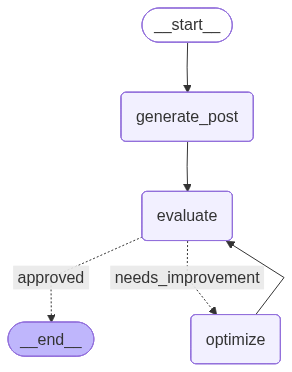

In [22]:
workflow

In [28]:
response = workflow.invoke(
    {"topic": "abcd", "iterations": 0, "max_iteration": 3}
)

In [29]:
response

{'topic': 'abcd',
 'post': 'Here are a few options, playing with different angles to boost the humor and virality:\n\n**Option 1 (More relatable struggle):**\n\n> "abcd" is basically the alphabet\'s way of saying "I\'m done with this." We\'ve all been there. #AlphabetStruggles #Mood\n\n**Option 2 (Slightly more absurd personification):**\n\n> The alphabet just *really* checked out after \'c\'. Pretty sure \'d\' was just a sigh. #AlphabetStruggles #Relatable\n\n**Option 3 (Focus on the "giving up" energy):**\n\n> "abcd" is the alphabet\'s official surrender flag. I respect the honesty. #AlphabetStruggles #Vibes\n\n**Option 4 (Short and punchy):**\n\n> The alphabet giving up at "abcd" is a whole mood. #AlphabetStruggles\n\n**Why these might be more viral:**\n\n*   **Stronger Verbs/Imagery:** "Checked out," "surrender flag," "sigh" are more evocative than just "giving up."\n*   **Relatability Amplified:** Phrases like "We\'ve all been there" or "a whole mood" directly connect with the aud